In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
#import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2024-09-18 00:48:51.238279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 00:48:51.331602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 00:48:51.331643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 00:48:51.343672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 00:48:51.372045: I tensorflow/core/platform/cpu_feature_guar

In [15]:
save_plots = False
plot_dir = '../plots/plots_2024-09-17'

## Load and prep emu

In [4]:
# need to modify this on hyperion
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


  0% (0 of 6922240) |                    | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (270336 of 6922240) |               | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (1581056 of 6922240) |###           | Elapsed Time: 0:00:00 ETA:   0:00:00


 57% (3948544 of 6922240) |#######       | Elapsed Time: 0:00:00 ETA:   0:00:00
 95% (6578176 of 6922240) |############# | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (6922240 of 6922240) |##############| Elapsed Time: 0:00:00 Time:  0:00:00
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load lib and p(k)s

In [7]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

#tag_params = '_p3_n500'
tag_params = '_p5_n50'
tag_mocks = tag_params
tag_fields = '_deconvolved'
#dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'
dir_mocks = f'/data/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[1,0,0,0]'
tag_pk = '_b1000'
tag_pk_zspace = '_b1000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

# idxs_LH = np.sort([int(re.search(r'LH(\d+)', dir_mocks).group(1)) \
#         for dir_mocks in os.listdir(dir_mocks) \
#         if re.search(r'LH\d+', dir_mocks)])
# idxs_LH = np.sort([int(re.search(r'_(\d+)', dir_pks_zspace).group(1)) \
#         for dir_pks_zspace in os.listdir(dir_pks_zspace) \
#         if re.search(r'_\d+', dir_pks_zspace)])

#idxs_LH = np.arange(100)
#idxs_LH = np.arange(1)

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()

idxs_LH = list(params_df.index.values)
n_lib = len(idxs_LH)

print(n_lib)

50


### Load data 

In [9]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(50, 30)


In [10]:
# overall quantities
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 10 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    param_dict.update(param_dict_fixed)
    cosmo_params_emu = utils.get_cosmo_emu(param_dict)
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)
print(Pk_emu.shape)

0
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
10
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote v

In [19]:
expfactor = 1.0
kaiser_boosts = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 10 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    cosmo = utils.get_cosmo(param_dict)
    # kaiser boost only depends on k if neutrino mass is nonzero
    # for kaiser boost, the bias is the linear EULERIAN bias!
    # which is b1_eul = 1 + b1_lag
    bias_eulerian = 1 + bias_params[0]
    kaiser_boosts.append( cosmo.Kaiser_boost(expfactor, l=0, bias=bias_eulerian) )

0
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param w

In [20]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

In [21]:
print(np.min(kaiser_boosts), np.max(kaiser_boosts))

1.1577268796732252 1.21898804518912


## Plot

/tmp/ipykernel_908209/1759589267.py:41: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_908209/1759589267.py:42: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_908209/1759589267.py:48: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_908209/1759589267.py:53: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7f0cd43b8fd0>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x7f0d583a3810>, <matplotlib.lines.Line2D object at 0x7f0cd415cf10>] ['median', '16-84 percentile']


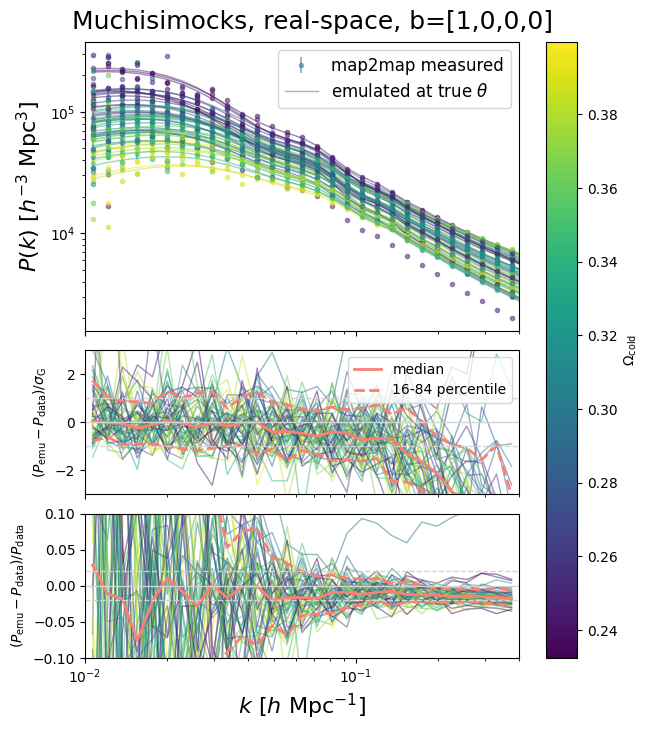

In [16]:
n_plot = n_lib

#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-3, 3)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_908209/1029723778.py:48: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_908209/1029723778.py:49: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_908209/1029723778.py:59: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/tmp/ipykernel_908209/1029723778.py:69: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x7f0ea8188fd0>, <matplotlib.lines.Line2D object at 0x7f0ea815a810>, <matplotlib.lines.Line2D object at 0x7f0ea81e0e10>, <matplotlib.lines.Line2D object at 0x7f0ea81e1690>, <matplotlib.lines.Line2D object at 0x7f0ea81e3c10>, <matplotlib.lines.Line2D object at 0x7f0ea81d0490>, <matplotlib.lines.Line2D object at 0x7f0ea81d2690>, <matplotlib.lines.Line2D object at 0x7f0ea81d2f10>, <matplotlib.lines.Line2D object at 0x7f0ea84dd210>, <matplotlib.lines.Line2D object at 0x7f0ea84dda50>, <matplotlib.lines.Line2D object at 0x7f0ea84dfc50>, <matplotlib.lines.Line2D object at 0x7f0ea84cc350>, <matplotlib.lines.Line2D object at 0x7f0ea84cd950>, <matplotlib.lines.Line2D object at 0x7f0ea84cec10>, <matplotlib.lines.Line2D object at 0x7f0ea8481c10>, <matplotlib.lines.Line2D object at 0x7f0ea84831d0>, <matplotlib.lines.Line2D object at 0x7f0ea8481010>, <matplotlib.lines.Line2D object at 0x7f0ea84ee3d0>, <matplotlib.lines.Line2D object at 0x7f0ea84ee390>, <matplotlib

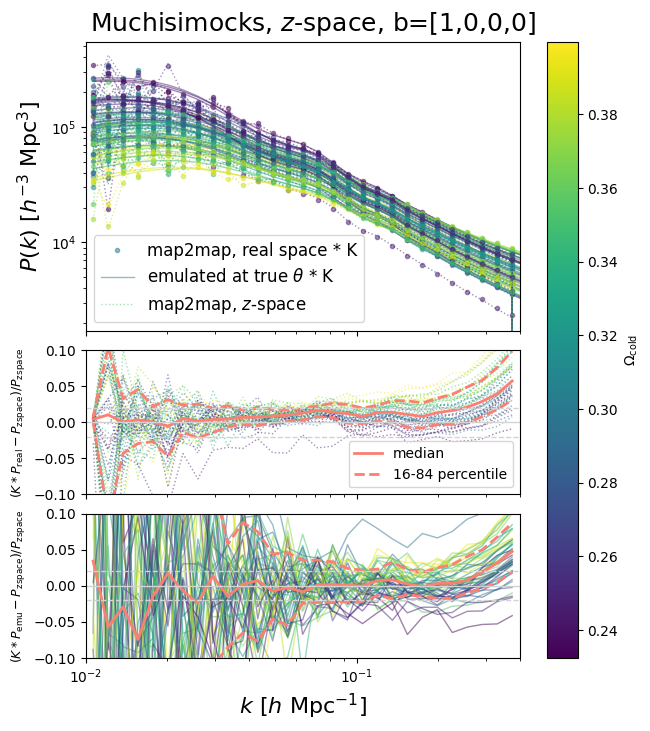

In [23]:
n_plot = n_lib

#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_908209/4004517499.py:47: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_908209/4004517499.py:54: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7f0ea8689690>, <matplotlib.lines.Line2D object at 0x7f0ec434bdd0>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x7f0ec46c9450>, <matplotlib.lines.Line2D object at 0x7f0ec47637d0>] ['median', '16-84 percentile']


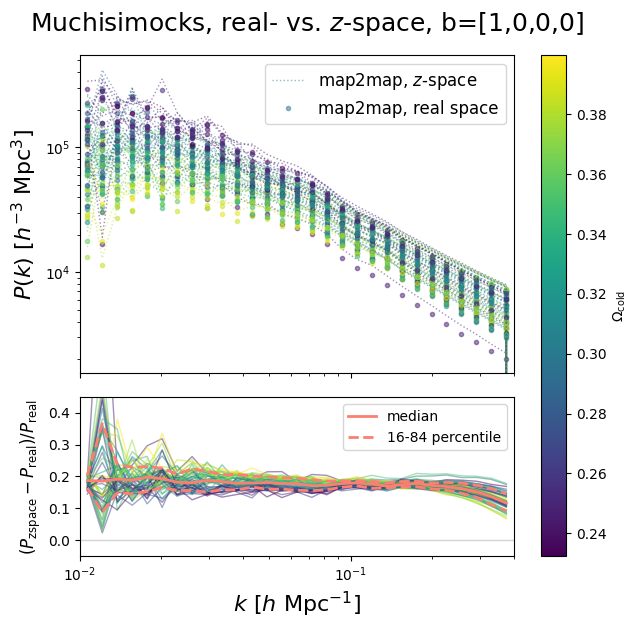

In [25]:
n_plot = n_lib

#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.45)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')